In [1]:
import math
import random
import numpy as np
# import matplotlib.pyplot as plt

# %matplotlib inline

In [39]:
def f(x):
    return 3*x**2 + 2*x - 1 

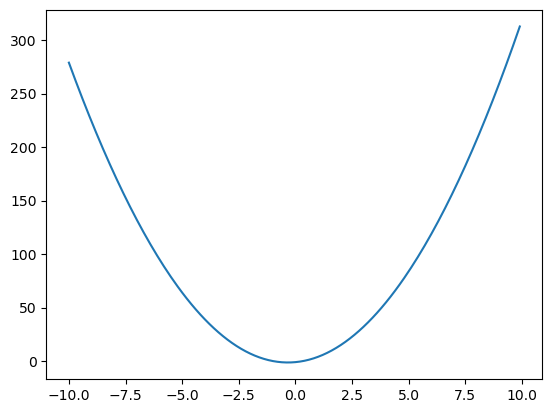

In [40]:
xs = np.arange(-10, 10, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [41]:
h = 0.000001 # don't make it too small, otherwise it will be a numerical error
x = -1/3
(f(x+h) - f(x))/h

3.000044657142098e-06

In [42]:
# multiple variables

h = 0.001

# inputs
a = 2.0
b = 3.0
c = 4.0

d1 = 2*a*b + c
c += h
d2 = 2*a*b + c

print('d1', d1)
print('d2', d2)
print('numerical derivative', (d2-d1)/h)

d1 16.0
d2 16.001
numerical derivative 1.0000000000012221


### Moving towards NN

In [2]:
# Value object
class Value:
     
    def __init__(self, data, _children=(), _op='', label=''):
          self.data = data
          self.grad = 0.0
          self._prev = set(_children)
          self._op = _op
          self.label = label
          self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
          other = other if isinstance(other, Value) else Value(other)
          out = Value(self.data + other.data, (self, other), '+')

          def _backward():
             self.grad += 1 * out.grad
             other.grad += 1 * out.grad

          out._backward = _backward
          
          return out
    
    def __radd__(self, other): # other + self
                  return self + other
    
    def __mul__(self, other):
          other = other if isinstance(other, Value) else Value(other)
          out = Value(self.data*other.data, (self, other), '*')
          
          def _backward():
             self.grad += other.data * out.grad
             other.grad += self.data * out.grad
          
          out._backward = _backward

          return out
    
    def __pow__(self,other):
          assert isinstance(other, (int, float))
          out = Value(self.data**other, (self,), f'**{other}')

          def _backward():
                self.grad += (other * (self.data**(other-1))) * out.grad

          out._backward = _backward

          return out
    
    
    def __rmul__(self, other): # other * self
              return self * other
    
    def __truediv__(self, other):
          return self * (other**-1)
    
    def __sub__(self, other):
          return self + (-1)*(other)
    
    def tanh(self):
         x = self.data
         t =  (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
         out = Value(t, (self,), 'tanh')

         def _backward():
            self.grad += (1 - t**2) * out.grad
          
         out._backward = _backward

         return out
    
    def exp(self):
          out = Value(math.exp(self.data), (self,), 'exp')

          def _backward():
                self.grad += math.exp(self.data) * out.grad

          out._backward = _backward
          return out


    def backward(self):
      topo = []
      visited = set()
      def build_topo(v):
            if v not in visited:
                  visited.add(v)
                  for child in v._prev:
                        build_topo(child)
                  topo.append(v)
      build_topo(self)
      self.grad = 1.0
      for node in reversed(topo):
            node._backward()


In [22]:
a = Value(2.0)
b = Value(4.0)
b - a

Value(data=2.0)

In [12]:
a = Value(-2.0, label='a')
b = Value(2.0, label='b')
c = Value(1.5, label='c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label = 'f')
L = e*f; L.label = 'L'
L

Value(data=5.0)

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir':'LR'}) # TB top to bottom, LR left to right
    nodes, edges = trace(root)

    # drawing the nodes
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    # drawing the edges
    for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)    
    
    return dot

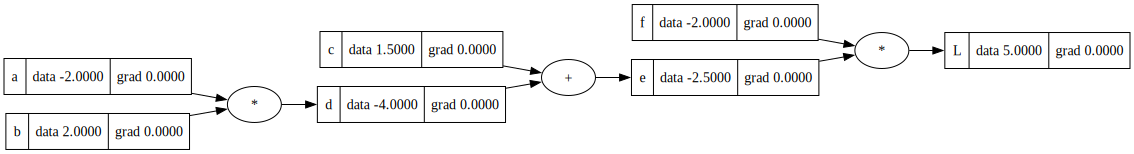

In [13]:
draw_dot(L)

### Computing Gradients (Manual)

In [64]:
def lol():

    h = 0.001 

    a = Value(-2.0, label='a')
    b = Value(2.0, label='b')
    c = Value(1.5, label='c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(-2.0, label = 'f')
    L = e*f; L.label = 'L'
    L1 = L.data

    a = Value(-2.0, label='a')
    b = Value(2.0, label='b')
    b.data += h
    c = Value(1.5, label='c')
    d = a*b; d.label = 'd'
    e = d + c; e.label = 'e'
    f = Value(-2.0, label = 'f')
    L = e*f; L.label = 'L'
    L2 = L.data

    return (L2 - L1)/h

In [65]:
lol()

3.9999999999995595

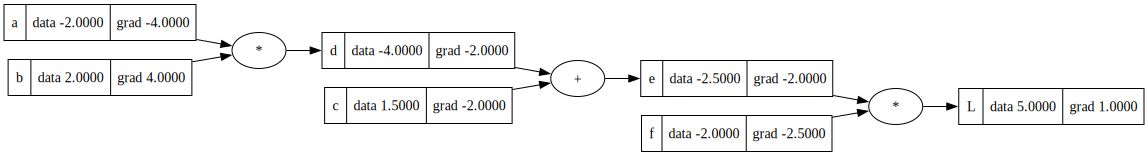

In [61]:
# Let set gradients manually from the above code and expectations and visualize the graph
L.grad = 1
f.grad = -2.5 # since d = e*f
e.grad = -2   # e = -2.5 and f = -2

draw_dot(L)

In [60]:
# to find the derivative of L w.r.t d
# chain rule dL/dd = dL/de * de/dd
# dL/de = f and de/dd = 1
# dL/dd = f = -2
# similarly dL/dc = f

d.grad = -2.0
c.grad = -2.0

# finally we compute change with 
a.grad = -4.0 # dL/da = dL/dd * dd/da
b.grad = 4.0  # dL/db = dL/dd * dd/db

In [66]:
# the inputs are a, b, c. let us increase them by small amount and see the change in L

a.data += 0.01* a.grad
b.data += 0.01* b.grad
c.data += 0.01* c.grad

d = a*b
e = d + c
L = e*f

L

Value(data=5.3632)

### Building a Neuron

In [195]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.88137, label='b')

# output
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

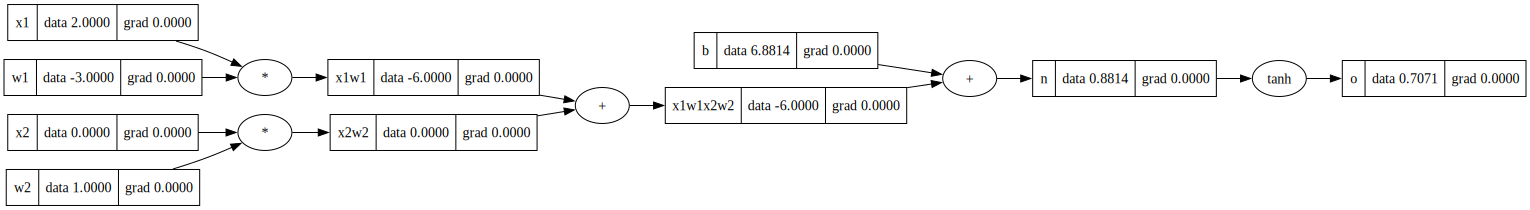

In [196]:
draw_dot(o)

In [98]:
# manual backpropagation
o.grad = 1.0
n.grad = 1 - o.data**2 # derivative of tanh
x1w1x2w2.grad = n.grad # n = x1w1x2w2 + b
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad # x1w1x2w2 = x1w1 + x2w2
x2w2.grad = x1w1x2w2.grad
w1.grad = x1w1.grad*x1.data # x1w1 = x1*w1
w2.grad = x2w2.grad*x2.data # x2w2 = x2*w2
x1.grad = x1w1.grad*w1.data
x2.grad = x2w2.grad*w2.data

### Automating Backpropogation

In [144]:
o.grad = 1.0

In [145]:
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()

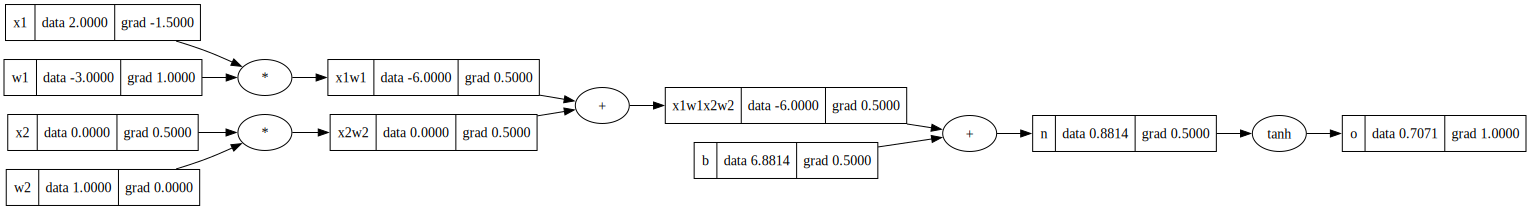

In [146]:
draw_dot(o)

In [132]:
# it is important to process the graph in reverse order, otherwise the gradients will be wrong
# we can ensure this by making a topolofical sort of the graph

In [197]:
o.backward()

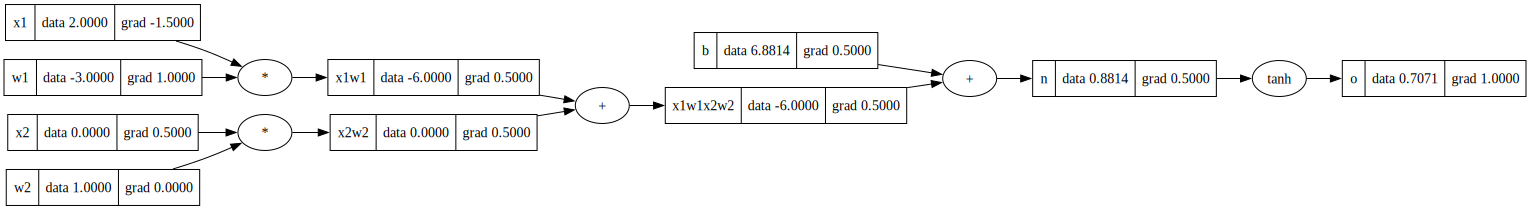

In [198]:
draw_dot(o)

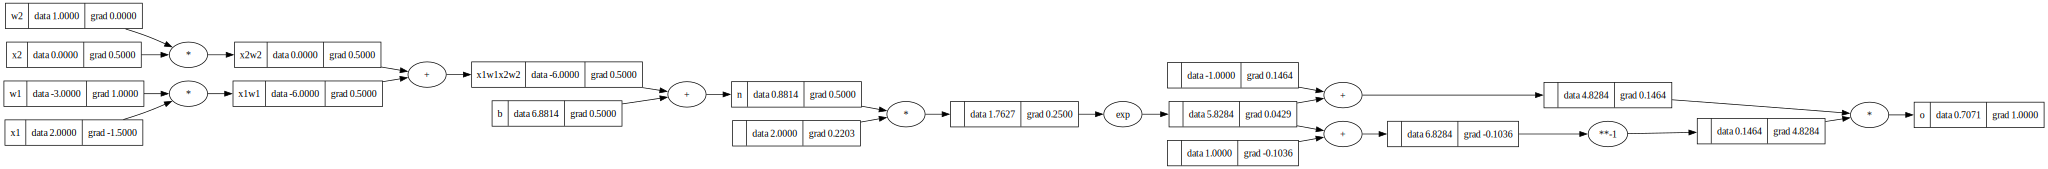

In [201]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.88137, label='b')

# output
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'
o.backward()
draw_dot(o)

### Implementing it in PyTorch

In [1]:
import torch

In [14]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.88137]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()

print(o.data.item())
print("--------")
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

0.7071050214706146
--------
-1.500007465833125
1.0000049772220834
0.5000024886110417
0.0


In [15]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [18]:
x1.grad

tensor([-1.5000], dtype=torch.float64)

### Building Neural Networks

In [4]:
class Neuron:

    def __init__(self, nin):
      self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
      self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
    # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

In [5]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        return [n(x) for n in self.neurons]

In [6]:
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [7]:
x = [2.0, 4.0]
n = Neuron(2)
n(x)

Value(data=-0.7200367580724454)

In [8]:
l = Layer(2,3)
l(x)

[Value(data=-0.9971898697306635),
 Value(data=-0.862709051717018),
 Value(data=0.995493382064373)]

In [9]:
x = [2.0, -1.5, 3.14]
mlp = MLP(2, [4, 4, 1])
mlp(x)

[Value(data=-0.8712834321800063)]

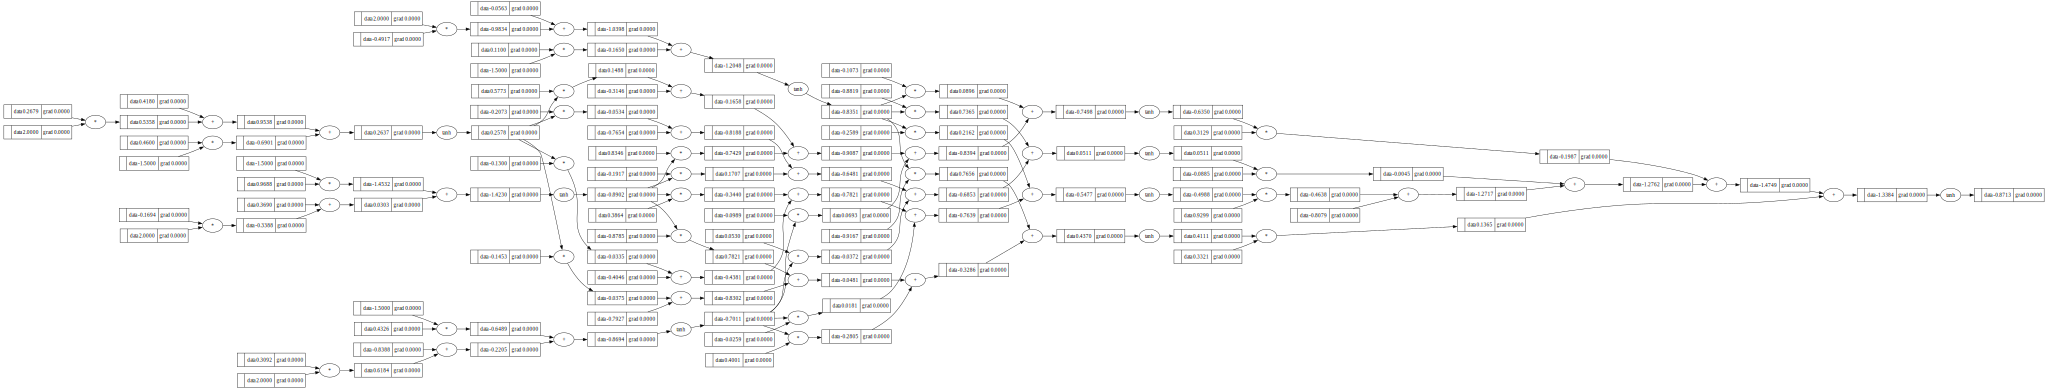

In [15]:
draw_dot(mlp(x)[0])